In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
plt.rcParams['figure.dpi'] = 100

# 0. Load location and groupings information

In [63]:
## Read samples location info
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'dc_222_samples_info.tsv'
file_data = glob(dir_path + file_name)[0]
INFO = pd.read_csv(file_data, sep='\t')[['sample_ID', 'rookery-region', 'Year', 'group-Lkadj', 
                                     'Management units - based on DNA', 'Post_dupe_depth_2_all_LKGATK_USE',
                                     'Exclude-all_GL_ROH_analyses', 'Sequencing_source-type', 'Stage_Class']]
INFO.rename(columns={'sample_ID':'sample', 
                     'rookery-region':'rookery', 
                     'Year':'year',
                     'group-Lkadj': 'group',
                     'Management units - based on DNA': 'MU',
                     'Post_dupe_depth_2_all_LKGATK_USE':'depth',
                     'Exclude-all_GL_ROH_analyses': 'exclude',
                     'Sequencing_source-type': 'batch',
                     'Stage_Class': 'stage'}, inplace=True)

## 0.1 Define colors

In [112]:
rookery_palette_dict = {
    'Mexico': '#1f77b4',
    'Atl Costa Rica': '#005a32',
    'Indonesia': '#d62728',
    'Pacific Costa Rica': '#7570b3',
    'Papua New Guinea': '#dd3497',
    'Solomon Islands': '#fde0dd',
    'Malaysia': '#2ca02c',
    'South Africa': '#17becf',
    'Ghana': '#ff7f0e',
    'Gabon': '#fdd0a2',   
    'French Guiana-Suriname': '#8c564b',
    'Virgin Islands': '#d6eaf8',
    'Florida': '#d9f0a3',
    'na': '#000000',
    'unknown': '#7f7f7f'}

mu_palette_dict = {
    'Eastern Pacific': '#1f77b4',
    'Western Pacific': '#d62728',
    'Northwest Caribbean': '#005a32',
    'Northeast Caribbean': '#6a51a3',
    'Northern Caribbean': '#d9f0a3',
    'South Africa': '#17becf',
    'SE Atlantic/West Africa': '#ff7f0e',
    'South-east Caribbean': '#8c564b',
    'Indo-Western Pacific': '#2ca02c',
    'na': '#000000',
    'unknown': '#7f7f7f'}

batch_palette_dict = {
    'novo_UMass_Illumina_SR': '#1f77b4',
    'novo42_Illumina_SR': '#ff7f0e',
    'LR-getinfofromJH': '#2ca02c',
    'Duffy_Illumina_SR': '#d62728'}

population_palette_dict = {
    'larger_declining': '#d62728',
    'small_stable':'#1f77b4',
    'small_declining': '#005a32',
    'larger_stable': '#ff7f0e',
    'small_recovering': '#6a51a3'}

color_dict = {'MU': mu_palette_dict,
              'rookery': rookery_palette_dict,
              'batch': batch_palette_dict,
              'pops': population_palette_dict}

In [113]:
pop_order = ['larger_declining', 'small_stable', 'small_declining', 'larger_stable', 'small_recovering']

# 1. Genetic load analysis

In [114]:
## Read summary file with total number of variants by impact
dc = '222'
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = f'snpEff_{dc}/all_samples.snp_indel_hom_het_by_impact.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Assign location info to each sample
df = df[df['state'] != 'hom_ref']
df_all = pd.merge(df, INFO, on='sample')

## Exclude samples that are not for genetic load analysis
df_all['exclude'] = df_all['exclude'].fillna('include')

In [116]:
df_all.head(3)

sample    impact state  number variant             rookery    year  \
0  Z005878      HIGH   hom     125    snps  Pacific Costa Rica  1994.0   
1  Z005878  MODERATE   hom    2697    snps  Pacific Costa Rica  1994.0   
2  Z005878       LOW   hom    3352    snps  Pacific Costa Rica  1994.0   

              group               MU  depth  exclude               batch stage  
0  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR   NaN  
1  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR   NaN  
2  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR   NaN

## 1.1. Plot total number of variants by impact
### NB: each impact can additionally be MODIFIER (snpEff can annotate a SNP as both HIGH and MODIFIER) => MODIFIER here are variants that are annotated ONLY as modifier and no other class! 

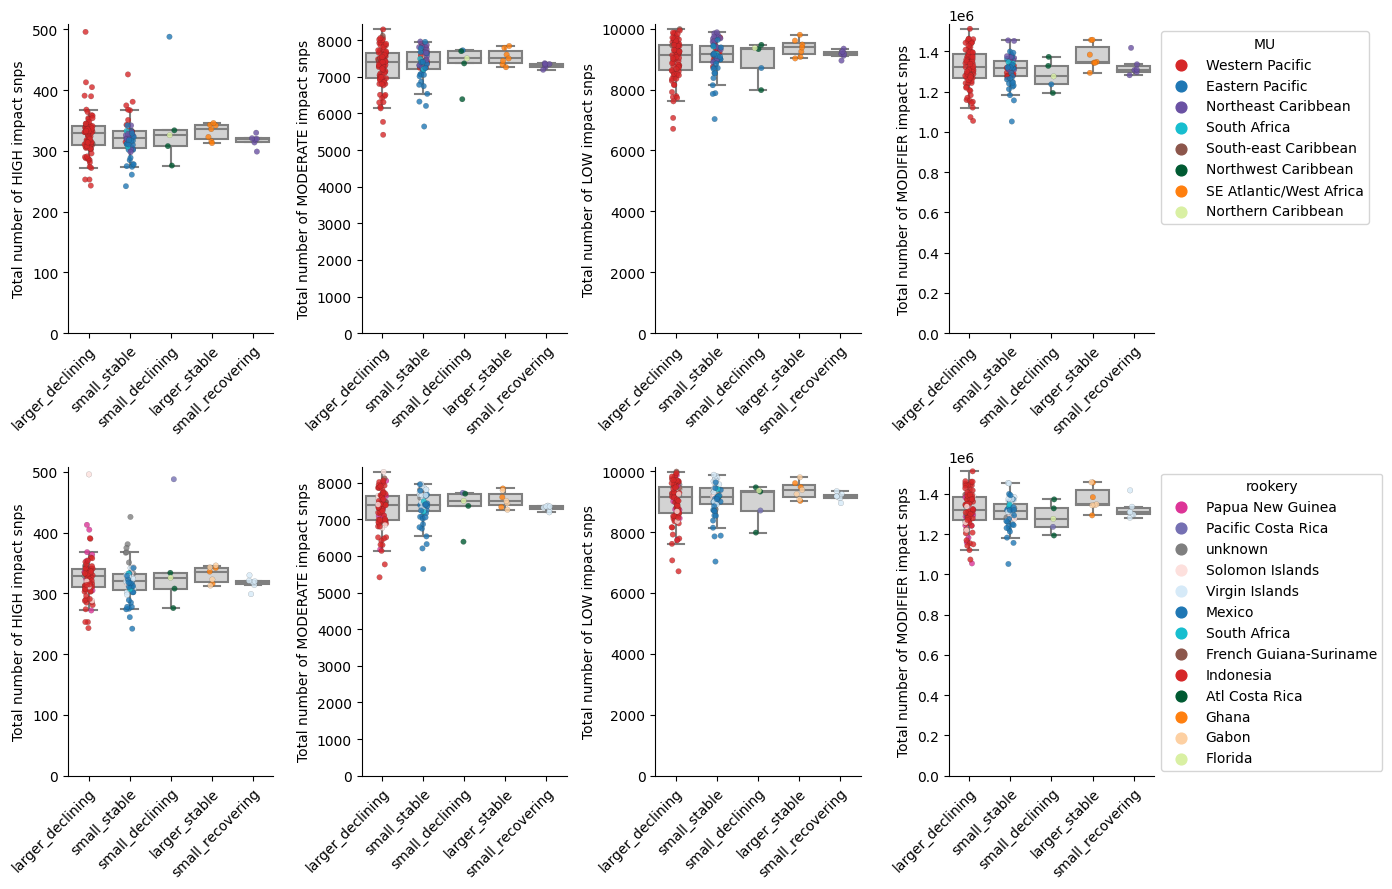

In [117]:
grouped_df = df_all.groupby(['sample', 'impact', 'MU', 'rookery', 'year', 'group', 'exclude', 'batch']).sum().reset_index()

# Exclude 'MODIFIER' snps
# grouped_df = grouped_df[grouped_df['impact'] != 'MODIFIER']
impacts = ['HIGH', 'MODERATE', 'LOW', 'MODIFIER']

fig, axes = plt.subplots(2, len(impacts), figsize=(14, 9))

groups = ['MU', 'rookery']

for j in range(len(groups)):
    for i, impact in enumerate(impacts):
   
        axi = axes[j, i]
        dfi = grouped_df[grouped_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        group = groups[j]
        p = color_dict[group]

        sns.boxplot(ax=axi, data=dfi, x='group', y='number', showfliers=False, 
                    color="lightgrey", order=pop_order)
        sns.stripplot(ax=axi, data=dfi, x='group', y='number',  hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.1, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Total number of {impact} impact snps')
        axi.set_xlabel('')
        axi.set_ylim(0, None)
        
        if i != len(impacts)-1:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'total_number_variants_by_impact.all.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

## Plot main groups only

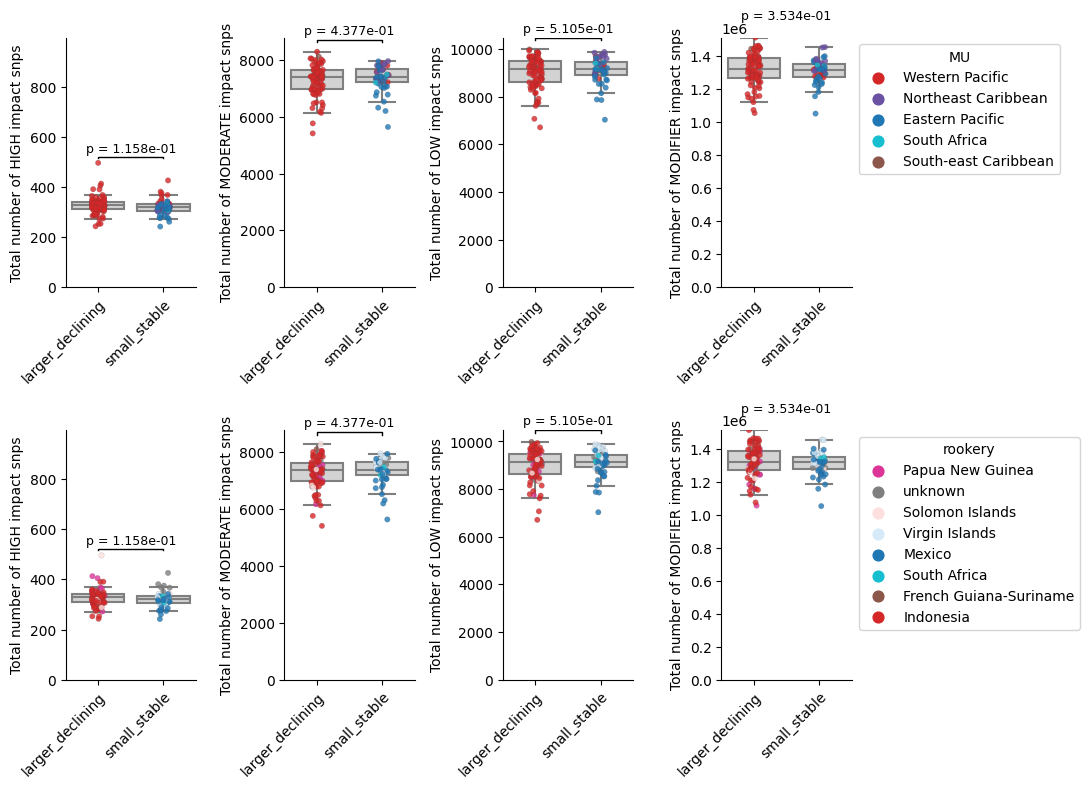

In [118]:
impacts = ['HIGH', 'MODERATE', 'LOW', 'MODIFIER']
groups = ['MU', 'rookery']
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]

fig, axes = plt.subplots(2, len(impacts), figsize=(11, 8))

for j in range(len(groups)):
    for i, impact in enumerate(impacts):
   
        axi = axes[j, i]
        dfi = grouped_df[grouped_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        dfi = dfi[dfi['group'].isin(pops)]
        
        group = groups[j]
        p = color_dict[group]

        # Subset data per population
        data1 = dfi[dfi['group'] == g1]['number']
        data2 = dfi[dfi['group'] == g2]['number']

        # Perform Mann–Whitney U test
        stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
    
        sns.boxplot(ax=axi, data=dfi, x='group', y='number', showfliers=False, 
                    color="lightgrey", order=pop_order)
        sns.stripplot(ax=axi, data=dfi, x='group', y='number',  hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.1, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Total number of {impact} impact snps')
        axi.set_xlabel('')
        axi.set_ylim(0, max(dfi['number'])+500)
        
        # Add bar and p-value
        y_max = max(dfi['number']) * 1.05        
        axi.plot([0, 0, 1, 1], [y_max * 0.99, y_max, y_max, y_max * 0.99], lw=1, color='black')
        axi.text(0.5, y_max * 1.01, f"p = {pval:.3e}", ha='center', va='bottom', fontsize=9)
        
        if i != len(impacts)-1:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'total_number_variants_by_impact.L_S.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

## 1.2. Plot fraction of SNPs by impact

In [119]:
G = grouped_df.groupby(['sample']).sum().reset_index()[['sample', 'number']]
G.rename({'number': 'total'}, axis='columns', inplace=True)

merged_df = pd.merge(grouped_df, G, on='sample')
merged_df['fraction'] = merged_df['number'] / merged_df['total'] * 100
merged_df.head(3)

sample    impact               MU             rookery    year  \
0  Z005878      HIGH  Eastern Pacific  Pacific Costa Rica  1994.0   
1  Z005878       LOW  Eastern Pacific  Pacific Costa Rica  1994.0   
2  Z005878  MODERATE  Eastern Pacific  Pacific Costa Rica  1994.0   

              group  exclude               batch  number  depth   total  \
0  larger_declining  exclude  novo42_Illumina_SR     343  12.44  930930   
1  larger_declining  exclude  novo42_Illumina_SR    7812  12.44  930930   
2  larger_declining  exclude  novo42_Illumina_SR    6430  12.44  930930   

   fraction  
0  0.036845  
1  0.839161  
2  0.690707

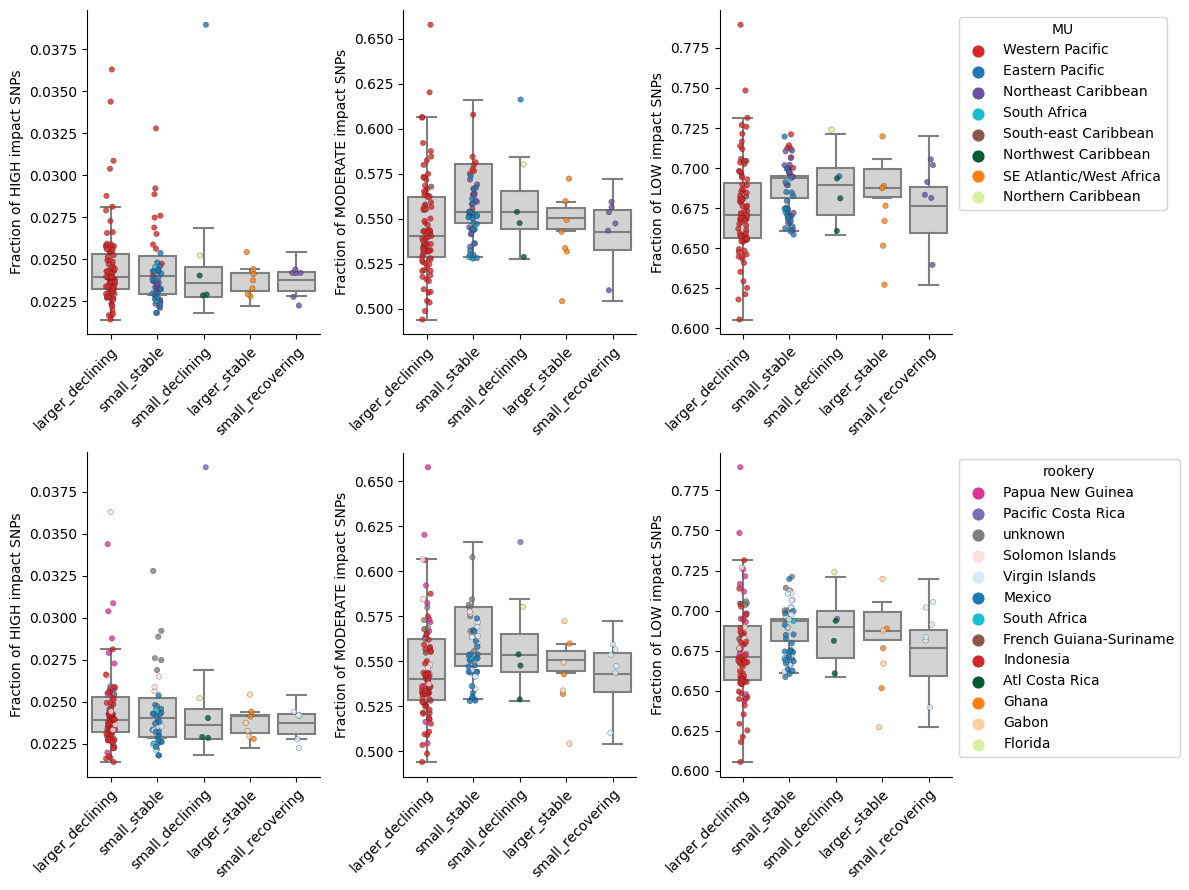

In [120]:
impacts = ['HIGH', 'MODERATE', 'LOW']
fig, axes = plt.subplots(2, len(impacts), figsize=(12, 9))

groups = ['MU', 'rookery']
y = 'fraction'

for j in range(len(groups)):
    for i, impact in enumerate(impacts):
   
        axi = axes[j, i]
        dfi = merged_df[merged_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        group = groups[j]
        p = color_dict[group]
        
        sns.boxplot(ax=axi, data=dfi, x='group', y=y, showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y=y, hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Fraction of {impact} impact SNPs')
        axi.set_xlabel('')

        if i != len(impacts)-1:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'fraction_variants_by_impact.all.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

## Plot main groups only

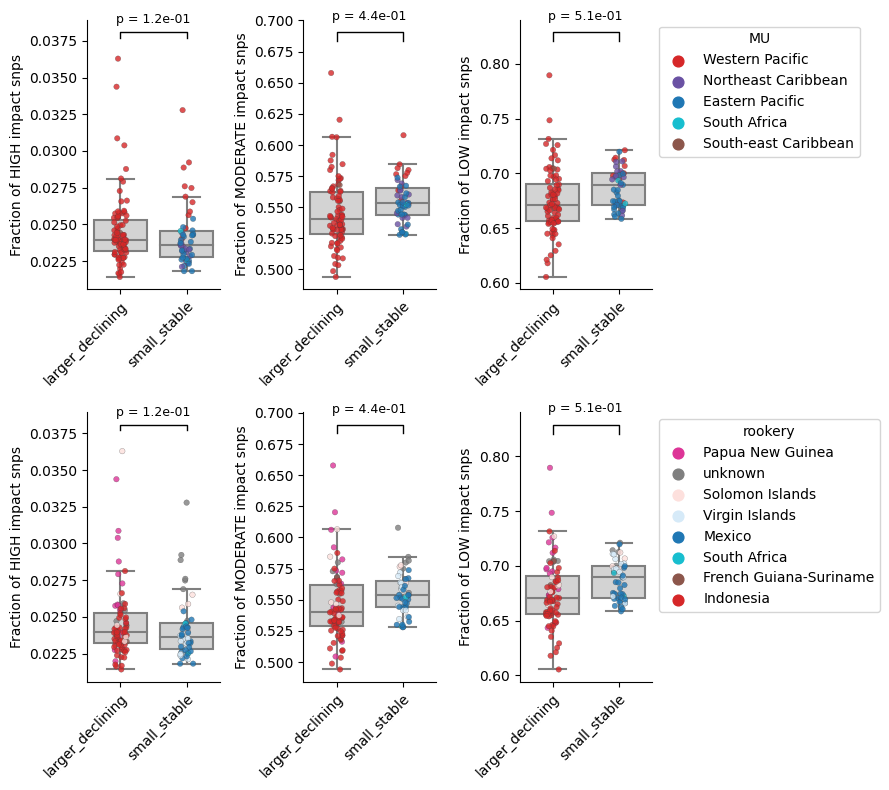

In [121]:
groups = ['MU', 'rookery']
impacts = ['HIGH', 'MODERATE', 'LOW']
variant = 'snps'
state = 'hom'
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]
y = 'fraction'

fig, axes = plt.subplots(2, 3, figsize = (9, 8))

for j in range(len(groups)):
    for i in range(len(impacts)):
        axi = axes[j][i]
        impact = impacts[i]
        
        dfi = merged_df[merged_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        dfi = dfi[dfi['group'].isin(pops)]
        
        group = groups[j]
        p = color_dict[group]

        # Subset data per population
        data1 = dfi[dfi['group'] == g1][y]
        data2 = dfi[dfi['group'] == g2][y]

        # Perform Mann–Whitney U test
        stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
        
        sns.boxplot(ax=axi, data=dfi, x='group', y=y, order=pop_order,
                    showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y=y, hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Fraction of {impact} impact snps')
        axi.set_xlabel('')
#         axi.set_ylim(0, max(dfi['number'])+500)
        
        # Add bar and p-value
        y_max = max(dfi['fraction']) * 1.05        
        axi.plot([0, 0, 1, 1], [y_max * 0.99, y_max, y_max, y_max * 0.99], lw=1, color='black')
        axi.text(0.5, y_max * 1.01, f"p = {pval:.1e}", ha='center', va='bottom', fontsize=9)
        
        if i != len(impacts)-1:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()


pdf_name = 'fraction_SNPs_by_impact.L_S.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

## 1.3. Plot homozygotes and heterozygotes by impact
### NB: all homozygotes are alt alleles! never 0/0, only 1/1, 1|1, and rarely 2/2, 3/3, ... etc for indels

### Since the majority of HIGH impact variants are LOF (>70%), classes HIGH and LOF are almost equivalent. Leave only LOF

## 1.6. Plot fraction of homozygots per impact: snpEff

In [122]:
grouped_df = df_all.groupby(['sample', 'impact', 'MU', 'rookery', 'year', 
                             'state', 'group', 'exclude', 'batch']).sum().reset_index()
# Exclude 'MODIFIER' snps
grouped_df = grouped_df[grouped_df['impact'] != 'MODIFIER']

# Include only homozygotes
grouped_df = grouped_df[grouped_df['state'] == 'hom']

In [123]:
G = grouped_df.groupby(['sample']).sum().reset_index()[['sample', 'number']]
G.rename({'number': 'total'}, axis='columns', inplace=True)

merged_df = pd.merge(grouped_df, G, on='sample')
merged_df['fraction'] = merged_df['number'] / merged_df['total'] * 100
merged_df.head(3)

sample    impact               MU             rookery    year state  \
0  Z005878      HIGH  Eastern Pacific  Pacific Costa Rica  1994.0   hom   
1  Z005878       LOW  Eastern Pacific  Pacific Costa Rica  1994.0   hom   
2  Z005878  MODERATE  Eastern Pacific  Pacific Costa Rica  1994.0   hom   

              group  exclude               batch  number  depth  total  \
0  larger_declining  exclude  novo42_Illumina_SR     125   6.22   6174   
1  larger_declining  exclude  novo42_Illumina_SR    3352   6.22   6174   
2  larger_declining  exclude  novo42_Illumina_SR    2697   6.22   6174   

    fraction  
0   2.024619  
1  54.292193  
2  43.683188

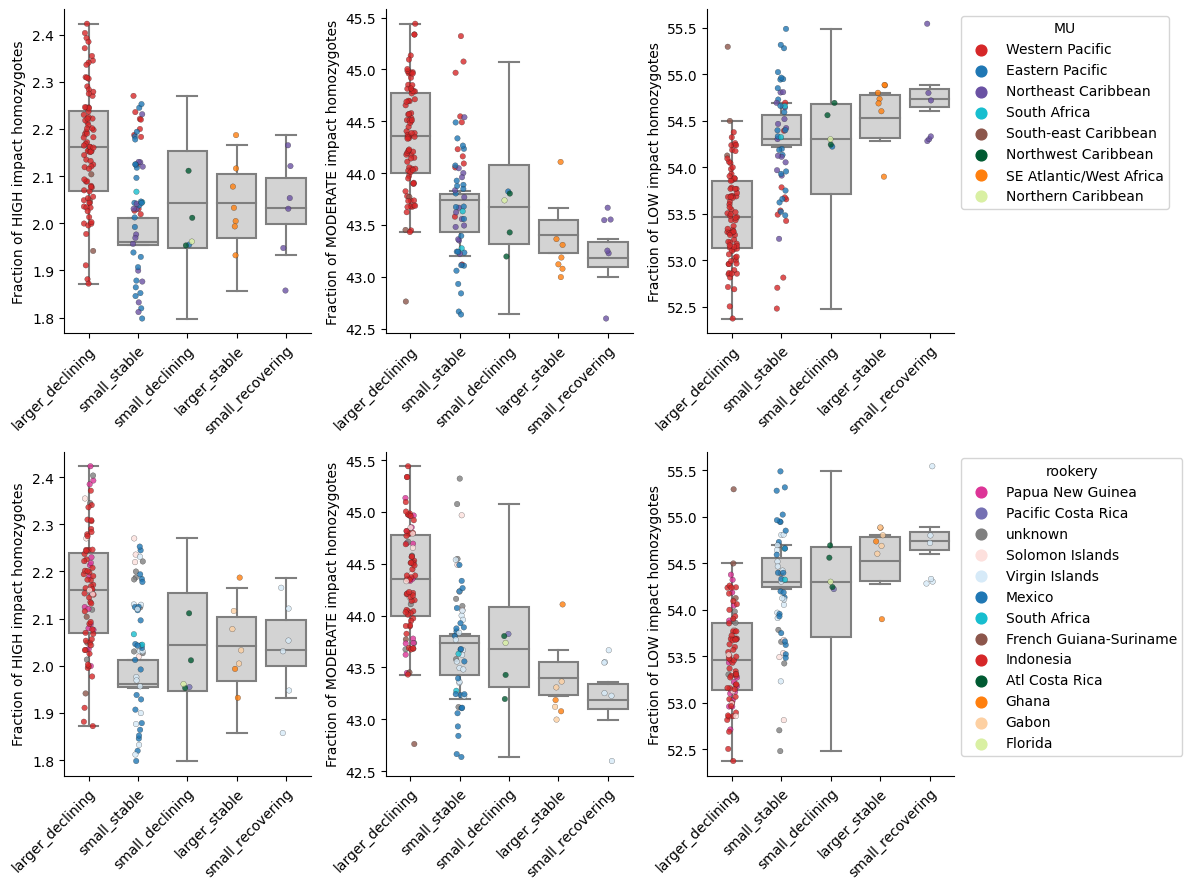

In [124]:
fig, axes = plt.subplots(2, 3, figsize=(12, 9))

groups = ['MU', 'rookery']
y = 'fraction'

for j in range(len(groups)):
    for i, impact in enumerate(impacts):
   
        axi = axes[j, i]
        dfi = merged_df[merged_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        group = groups[j]
        p = color_dict[group]
        
        sns.boxplot(ax=axi, data=dfi, x='group', y=y, showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y=y, hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Fraction of {impact} impact homozygotes')
        axi.set_xlabel('')

        
        if i != len(impacts)-1:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'fraction_homozygotes_by_impact.all.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

## Plot main groups only

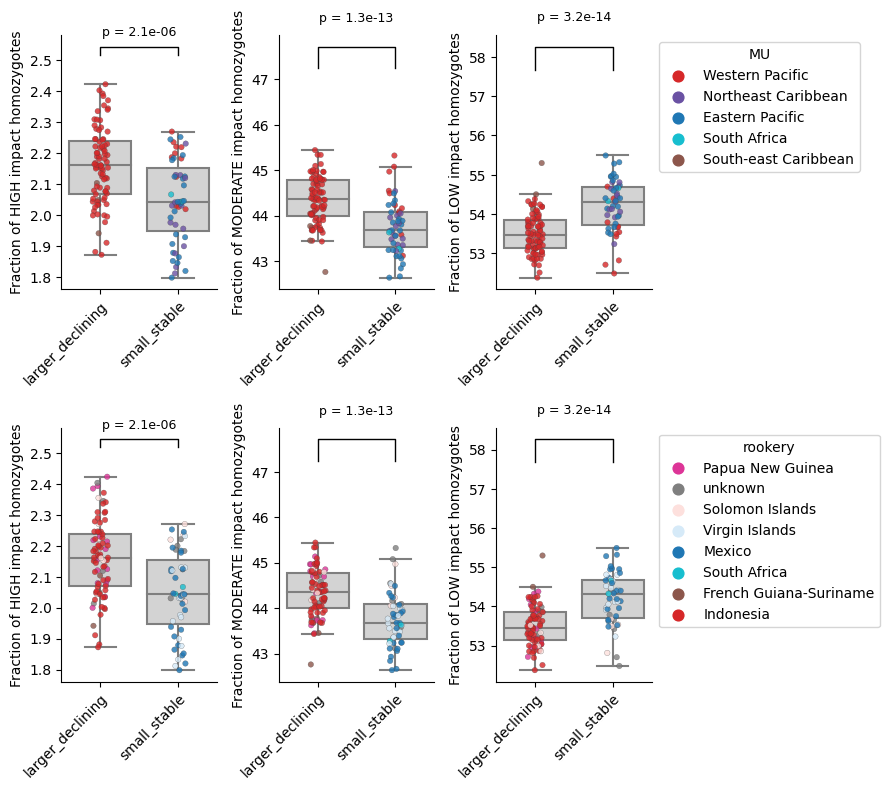

In [125]:
groups = ['MU', 'rookery']
impacts = ['HIGH', 'MODERATE', 'LOW']
variant = 'snps'
state = 'hom'
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]
y = 'fraction'

fig, axes = plt.subplots(2, 3, figsize = (9, 8))

for j in range(len(groups)):
    for i in range(len(impacts)):
        axi = axes[j][i]
        impact = impacts[i]
        
        dfi = merged_df[merged_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        dfi = dfi[dfi['group'].isin(pops)]
        
        group = groups[j]
        p = color_dict[group]

        # Subset data per population
        data1 = dfi[dfi['group'] == g1][y]
        data2 = dfi[dfi['group'] == g2][y]

        # Perform Mann–Whitney U test
        stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
        
        sns.boxplot(ax=axi, data=dfi, x='group', y=y, order=pop_order,
                    showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y=y, hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Fraction of {impact} impact homozygotes')
        axi.set_xlabel('')
#         axi.set_ylim(0, max(dfi['number'])+500)
        
        # Add bar and p-value
        y_max = max(dfi[y]) * 1.05        
        axi.plot([0, 0, 1, 1], [y_max * 0.99, y_max, y_max, y_max * 0.99], lw=1, color='black')
        axi.text(0.5, y_max * 1.01, f"p = {pval:.1e}", ha='center', va='bottom', fontsize=9)
        
        if i != len(impacts)-1:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'fraction_homozygotes_by_impact.L_S.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

## 1.8 ANNOVAR annotation!

In [127]:
dc = '222'
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = f'ANNOVAR_{dc}/all_samples.snp_indel_hom_het_by_impact.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
df = df[df['state'] != 'hom_ref']

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')
df_all['exclude'] = df_all['exclude'].fillna('include')
df_all.head(3)

sample    impact state  number variant             rookery    year  \
0  Z005878      HIGH   hom      28    snps  Pacific Costa Rica  1994.0   
1  Z005878  MODERATE   hom    2425    snps  Pacific Costa Rica  1994.0   
2  Z005878       LOW   hom    4792    snps  Pacific Costa Rica  1994.0   

              group               MU  depth  exclude               batch stage  
0  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR   NaN  
1  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR   NaN  
2  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR   NaN

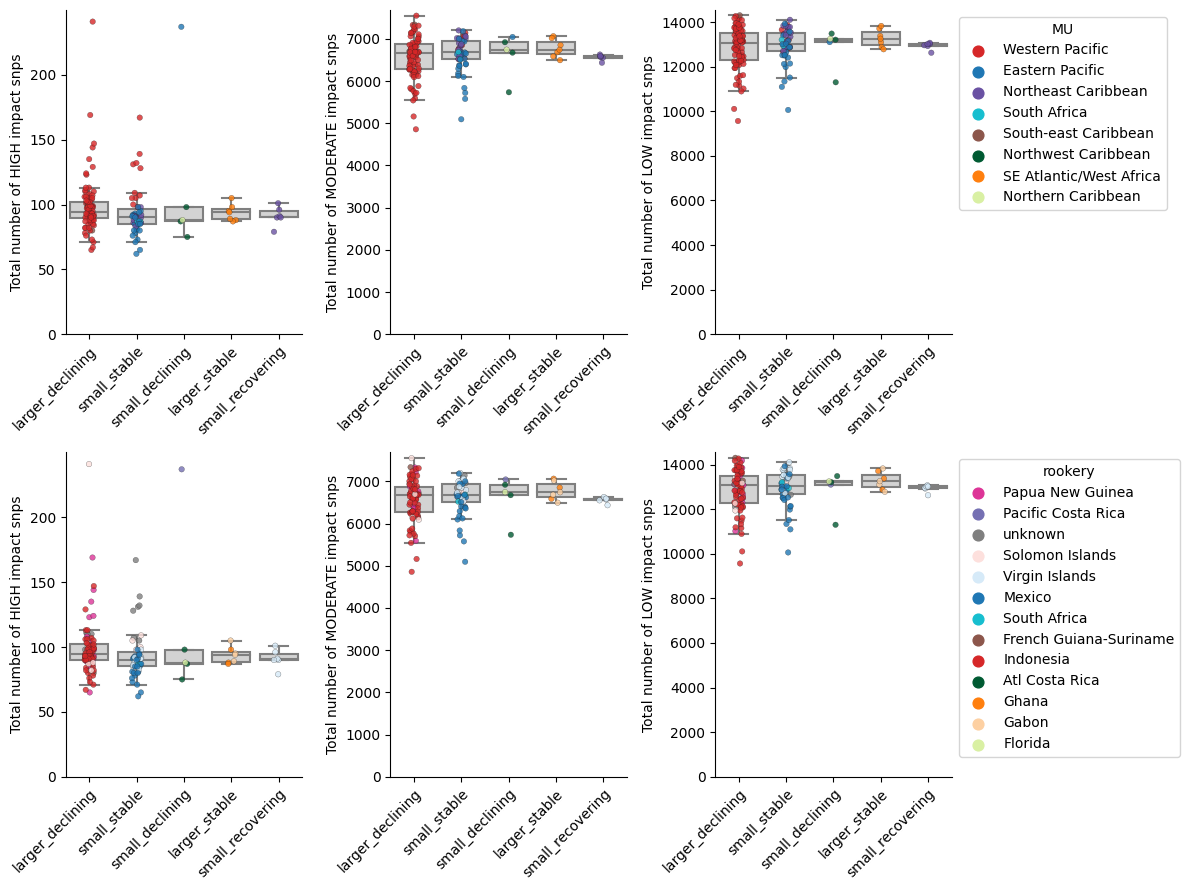

In [128]:
grouped_df = df_all.groupby(['sample', 'impact', 'MU', 'rookery', 'year', 'group', 'exclude', 'batch']).sum().reset_index()

# Exclude 'MODIFIER' snps
grouped_df = grouped_df[grouped_df['impact'] != 'MODIFIER']
impacts = ['HIGH', 'MODERATE', 'LOW']

fig, axes = plt.subplots(2, 3, figsize=(12, 9))

groups = ['MU', 'rookery']

for j in range(len(groups)):
    for i, impact in enumerate(impacts):
   
        axi = axes[j, i]
        dfi = grouped_df[grouped_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        group = groups[j]
        p = color_dict[group]

        sns.boxplot(ax=axi, data=dfi, x='group', y='number', showfliers=False, 
                    color="lightgrey", order=pop_order)
        sns.stripplot(ax=axi, data=dfi, x='group', y='number',  hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Total number of {impact} impact snps')
        axi.set_xlabel('')
        axi.set_ylim(0, None)
        
        if i != len(impacts)-1:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'total_number_snps_by_impact.all.ANNOVAR.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

## Plot main groups only

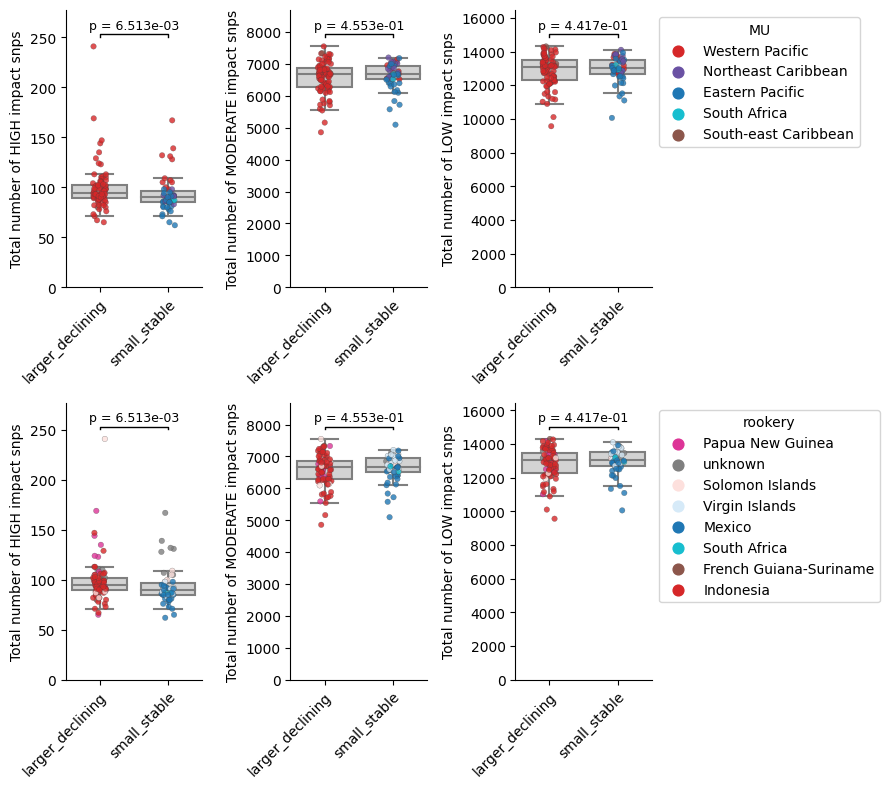

In [129]:
impacts = ['HIGH', 'MODERATE', 'LOW']
groups = ['MU', 'rookery']
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]

fig, axes = plt.subplots(2, 3, figsize=(9, 8))

for j in range(len(groups)):
    for i, impact in enumerate(impacts):
   
        axi = axes[j, i]
        dfi = grouped_df[grouped_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        dfi = dfi[dfi['group'].isin(pops)]
        
        group = groups[j]
        p = color_dict[group]

        # Subset data per population
        data1 = dfi[dfi['group'] == g1]['number']
        data2 = dfi[dfi['group'] == g2]['number']

        # Perform Mann–Whitney U test
        stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
    
        sns.boxplot(ax=axi, data=dfi, x='group', y='number', showfliers=False, 
                    color="lightgrey", order=pop_order)
        sns.stripplot(ax=axi, data=dfi, x='group', y='number',  hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Total number of {impact} impact snps')
        axi.set_xlabel('')
        axi.set_ylim(0, max(dfi['number'])*1.15)
        
        # Add bar and p-value
        y_max = max(dfi['number']) * 1.05        
        axi.plot([0, 0, 1, 1], [y_max * 0.99, y_max, y_max, y_max * 0.99], lw=1, color='black')
        axi.text(0.5, y_max * 1.01, f"p = {pval:.3e}", ha='center', va='bottom', fontsize=9)
        
        if i != len(impacts)-1:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'total_number_snps_by_impact.L_S.ANNOVAR.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

## 1.9. Plot fraction of homozygots per impact: ANNOVAR

In [134]:
G = grouped_df.groupby(['sample']).sum().reset_index()[['sample', 'number']]
G.rename({'number': 'total'}, axis='columns', inplace=True)

merged_df = pd.merge(grouped_df, G, on='sample')
merged_df['fraction'] = merged_df['number'] / merged_df['total'] * 100
merged_df.head(3)

sample    impact               MU             rookery    year  \
0  Z005878      HIGH  Eastern Pacific  Pacific Costa Rica  1994.0   
1  Z005878       LOW  Eastern Pacific  Pacific Costa Rica  1994.0   
2  Z005878  MODERATE  Eastern Pacific  Pacific Costa Rica  1994.0   

              group  exclude               batch  number  depth  total  \
0  larger_declining  exclude  novo42_Illumina_SR     124  12.44  17263   
1  larger_declining  exclude  novo42_Illumina_SR   11328  12.44  17263   
2  larger_declining  exclude  novo42_Illumina_SR    5811  12.44  17263   

    fraction  
0   0.718299  
1  65.620112  
2  33.661588

In [135]:
G = grouped_df.groupby(['sample']).sum().reset_index()[['sample', 'number']]
G.rename({'number': 'total'}, axis='columns', inplace=True)

merged_df = pd.merge(grouped_df, G, on='sample')
merged_df['fraction'] = merged_df['number'] / merged_df['total'] * 100
merged_df.head(3)

sample    impact               MU             rookery    year  \
0  Z005878      HIGH  Eastern Pacific  Pacific Costa Rica  1994.0   
1  Z005878       LOW  Eastern Pacific  Pacific Costa Rica  1994.0   
2  Z005878  MODERATE  Eastern Pacific  Pacific Costa Rica  1994.0   

              group  exclude               batch  number  depth  total  \
0  larger_declining  exclude  novo42_Illumina_SR     124  12.44  17263   
1  larger_declining  exclude  novo42_Illumina_SR   11328  12.44  17263   
2  larger_declining  exclude  novo42_Illumina_SR    5811  12.44  17263   

    fraction  
0   0.718299  
1  65.620112  
2  33.661588

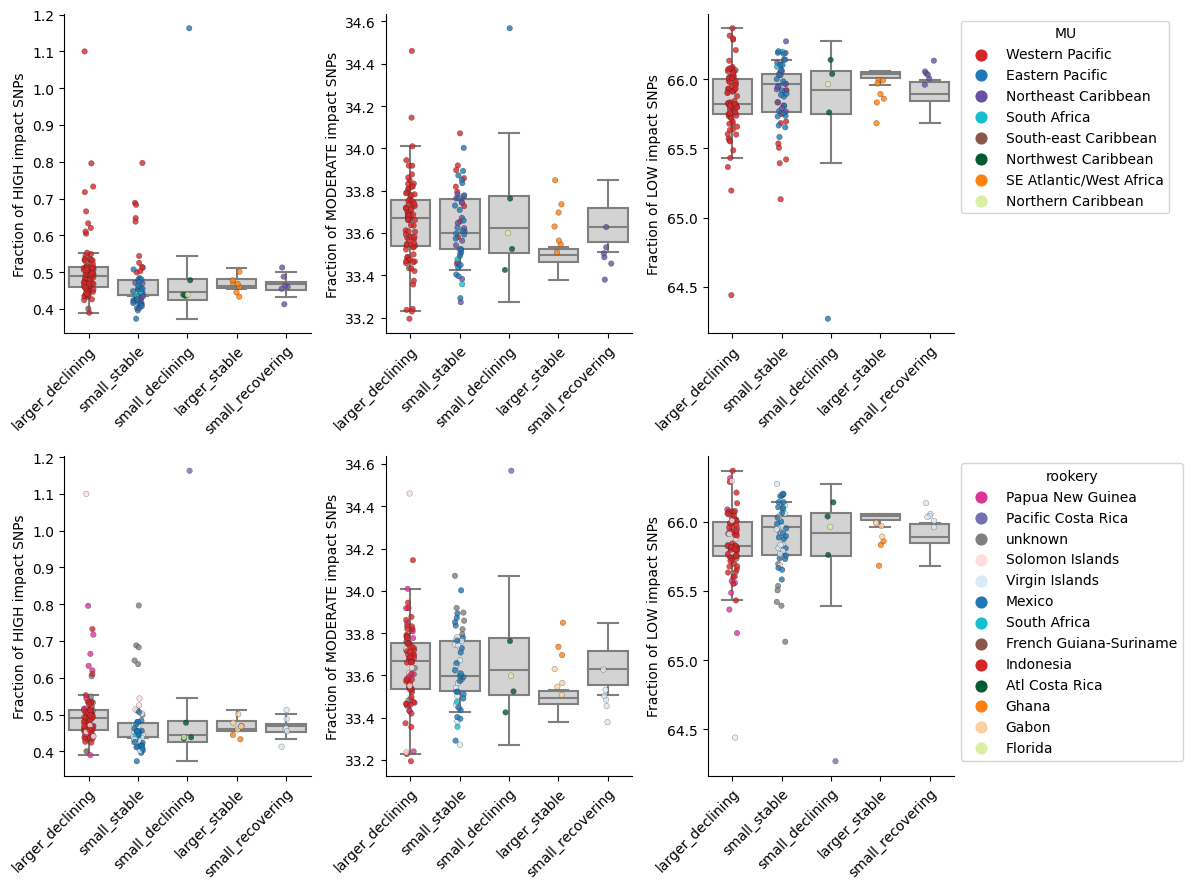

In [136]:
fig, axes = plt.subplots(2, 3, figsize=(12, 9))

groups = ['MU', 'rookery']
y = 'fraction'

for j in range(len(groups)):
    for i, impact in enumerate(impacts):
   
        axi = axes[j, i]
        dfi = merged_df[merged_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        group = groups[j]
        p = color_dict[group]
        
        sns.boxplot(ax=axi, data=dfi, x='group', y=y, showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y=y, hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Fraction of {impact} impact SNPs')
        axi.set_xlabel('')

        if i != len(impacts)-1:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'fraction_homozygotes_by_impact.all.ANNOVAR.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

## Plot main groups only: ANNOVAR

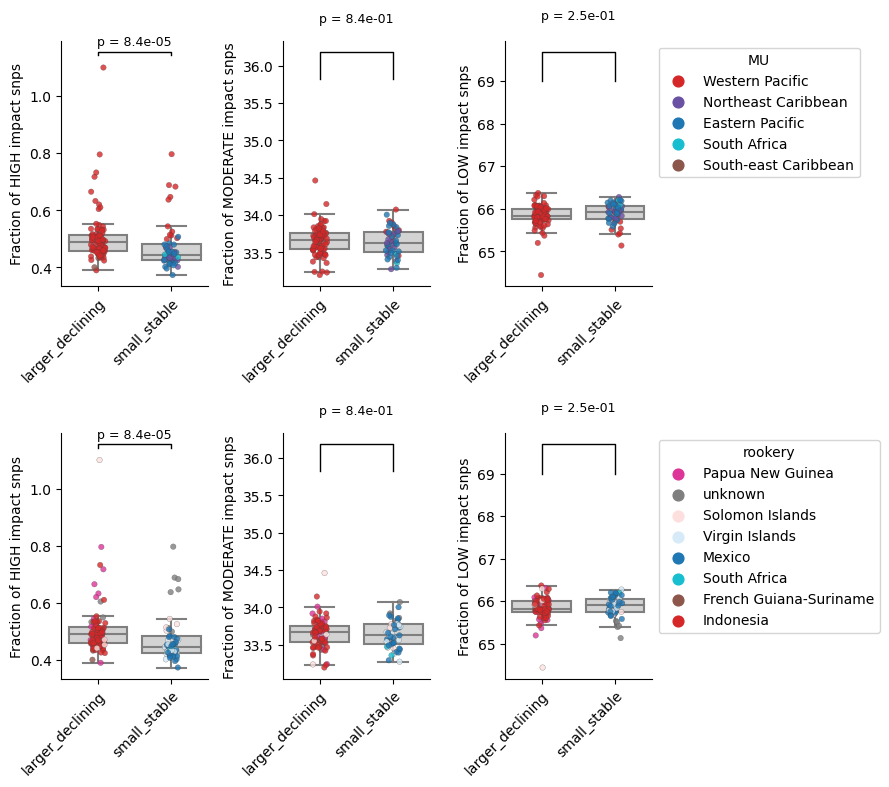

In [138]:
groups = ['MU', 'rookery']
impacts = ['HIGH', 'MODERATE', 'LOW']
variant = 'snps'
state = 'hom'
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]
y = 'fraction'

fig, axes = plt.subplots(2, 3, figsize = (9, 8))

for j in range(len(groups)):
    for i in range(len(impacts)):
        axi = axes[j][i]
        impact = impacts[i]
        
        dfi = merged_df[merged_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        dfi = dfi[dfi['group'].isin(pops)]
        
        group = groups[j]
        p = color_dict[group]

        # Subset data per population
        data1 = dfi[dfi['group'] == g1][y]
        data2 = dfi[dfi['group'] == g2][y]

        # Perform Mann–Whitney U test
        stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
        
        sns.boxplot(ax=axi, data=dfi, x='group', y=y, order=pop_order,
                    showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y=y, hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Fraction of {impact} impact snps')
        axi.set_xlabel('')
#         axi.set_ylim(0, max(dfi['number'])+500)
        
        # Add bar and p-value
        y_max = max(dfi[y]) * 1.05        
        axi.plot([0, 0, 1, 1], [y_max * 0.99, y_max, y_max, y_max * 0.99], lw=1, color='black')
        axi.text(0.5, y_max * 1.01, f"p = {pval:.1e}", ha='center', va='bottom', fontsize=9)
        
        if i != len(impacts)-1:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'fraction_homozygotes_by_impact.L_S.ANNOVAR.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

# 2. ROH analysis (PLINK)

In [139]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'ROH_222/all_samples_binned_ROH.tsv'
file_data = glob(dir_path + file_name)[0]
df_roh = pd.read_csv(file_data, sep='\t')
df_roh['L_total'] = df_roh['L_less100'] + df_roh['L_100_500'] + df_roh['L_more500']
df_roh['L_less500'] = df_roh['L_total'] - df_roh['L_100_500']
df_roh['L_ave'] = df_roh['L_total'] / df_roh['number_ROH']

## Assign location to each sample
df_all_roh = pd.merge(df_roh, INFO, on='sample')

df_all_roh['exclude'] = df_all_roh['exclude'].fillna('include')
df_all_roh.head(3)

sample                round  number_ROH   L_less100   L_100_500  \
0  Z005878  from_Lisa_window_20       10232  390751.609  835036.509   
1  Z005882  from_Lisa_window_20        7905  287180.462  693287.245   
2  Z005883  from_Lisa_window_20        7835  290399.621  666386.198   

   L_more500      L_total   L_less500       L_ave             rookery    year  \
0  78925.356  1304713.474  469676.965  127.513045  Pacific Costa Rica  1994.0   
1  70653.806  1051121.513  357834.268  132.969198  Pacific Costa Rica  1994.0   
2  86163.234  1042949.053  376562.855  133.114110  Pacific Costa Rica  1994.0   

              group               MU  depth  exclude               batch stage  
0  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR   NaN  
1  larger_declining  Eastern Pacific  10.18  exclude  novo42_Illumina_SR   NaN  
2  larger_declining  Eastern Pacific  10.91  exclude  novo42_Illumina_SR   NaN

## 2.1. Plot binned ROH for different sliding window sizes: Mexico samples
### relative ROH across samples stays consistent except for the same outlier: dc_11121_bb_noq

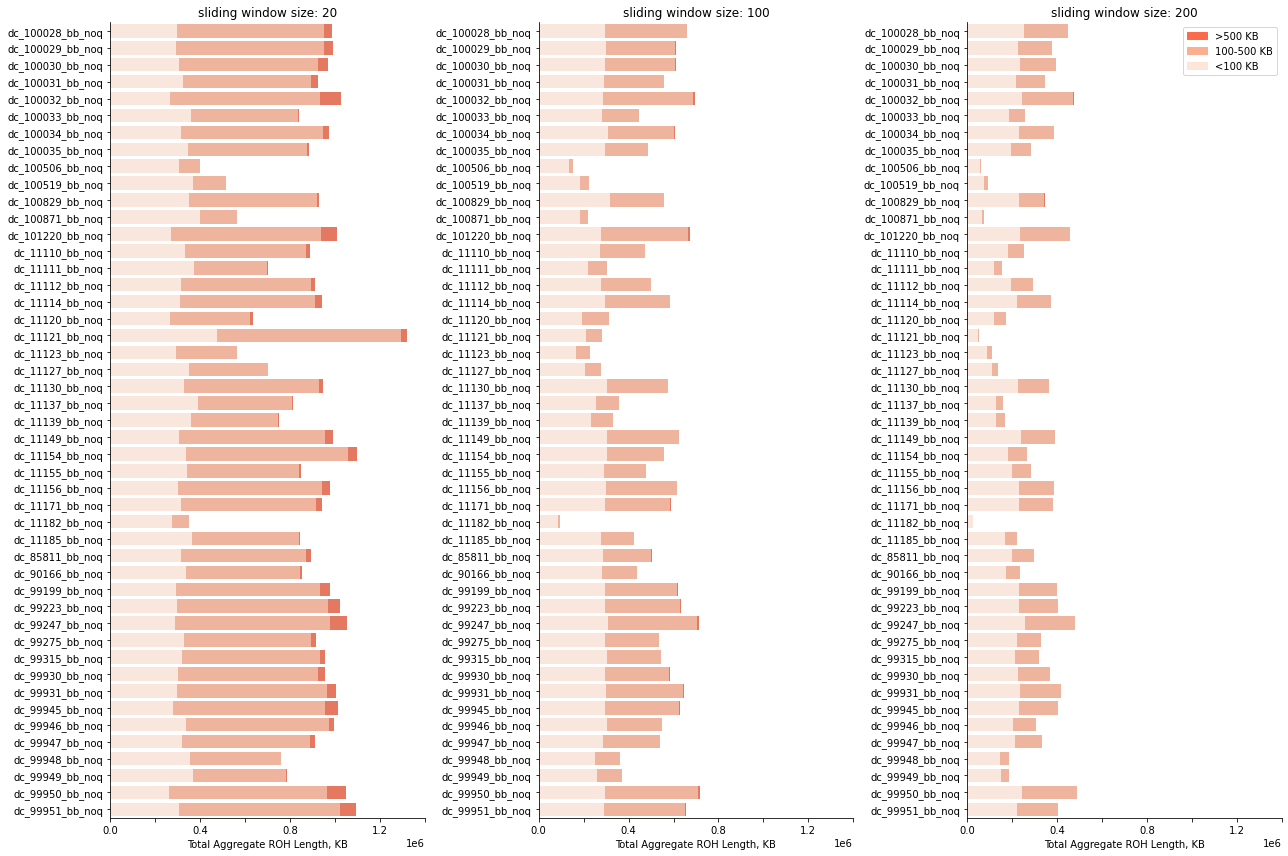

In [31]:
q_values = [20, 100, 200]
p = sns.color_palette(['#fee5d9', '#fcae91', '#fb6a4a', '#cb181d'])

fig, axes = plt.subplots(1, 3, figsize = (18, 12))

for i in range(3):
    axi = axes[i]
    q = q_values[i]
    round_q = 'from_Lisa_window_{}'.format(q)
    dfi = df_all_roh[(df_all_roh['round'] == round_q) & (df_all_roh['country'] == 'Mexico')]
    
    sns.barplot(ax=axi, data=dfi, y='sample', x='L_total', color=p[2])
    sns.barplot(ax=axi, data=dfi, y='sample', x='L_less500', color=p[1])
    sns.barplot(ax=axi, data=dfi, y='sample', x='L_less100', color=p[0])
    
    axi.set(title='sliding window size: {}'.format(q), 
            xlabel='Total Aggregate ROH Length, KB',
            ylabel='', 
            xlim=(0, 1_400_000))
    
    labels = axi.get_xticklabels()
    for x, label in enumerate(labels):
        if x % 2 == 1:
            label.set_visible(False)


# add custom legend
bin1 = mpatches.Patch(color=p[2], label='>500 KB')
bin2 = mpatches.Patch(color=p[1], label='100-500 KB')
bin3 = mpatches.Patch(color=p[0], label='<100 KB')
plt.legend(handles=[bin1, bin2, bin3], loc="upper right")

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 2.3 Calculate F_ROH (inbreeding coefficient) with PLINK and from_Lisa_window_20 parameters|

## 2.4. Plot correlation with depth: 
### total number of ROH, total length of ROH, and average length of ROH with a fixed sliding window = 20 
### => no correlation!           outlier sample: dc_11121_bb_noq

In [142]:
## Calculate F_ROH = L_ROH/Lgenome, in kb!!
L_genome = 2_164_762.090
df_all_roh['F_ROH'] = df_all_roh['L_total'] / L_genome

q = 20
round_q = 'from_Lisa_window_{}'.format(q)
df_roh = df_all_roh[df_all_roh['round'] == round_q][['sample', 'F_ROH', 'number_ROH', 
                                                     'L_less100', 'L_100_500', 'L_more500']]

## Merge with snpEff data - make sure df_all is from snpEff!
df_roh_merged = pd.merge(df_roh, df_all, on='sample')
df_roh_merged.head()

sample     F_ROH  number_ROH   L_less100   L_100_500  L_more500    impact  \
0  Z005878  0.602705       10232  390751.609  835036.509  78925.356      HIGH   
1  Z005878  0.602705       10232  390751.609  835036.509  78925.356  MODERATE   
2  Z005878  0.602705       10232  390751.609  835036.509  78925.356       LOW   
3  Z005878  0.602705       10232  390751.609  835036.509  78925.356  MODIFIER   
4  Z005878  0.602705       10232  390751.609  835036.509  78925.356      HIGH   

  state  number variant             rookery    year             group  \
0   hom      28    snps  Pacific Costa Rica  1994.0  larger_declining   
1   hom    2425    snps  Pacific Costa Rica  1994.0  larger_declining   
2   hom    4792    snps  Pacific Costa Rica  1994.0  larger_declining   
3   hom     359    snps  Pacific Costa Rica  1994.0  larger_declining   
4   het      96    snps  Pacific Costa Rica  1994.0  larger_declining   

                MU  depth  exclude               batch stage  
0  Eastern Pacific   6.22  exclude  novo42_Illumina_SR   NaN  
1  Eastern Pacific   6.22  exclude  novo42_Illumina_SR   NaN  
2  Eastern Pacific   6.22  exclude  novo42_Illumina_SR   NaN  
3  Eastern Pacific   6.22  exclude  novo42_Illumina_SR   NaN  
4  Eastern Pacific   6.22  exclude  novo42_Illumina_SR   NaN

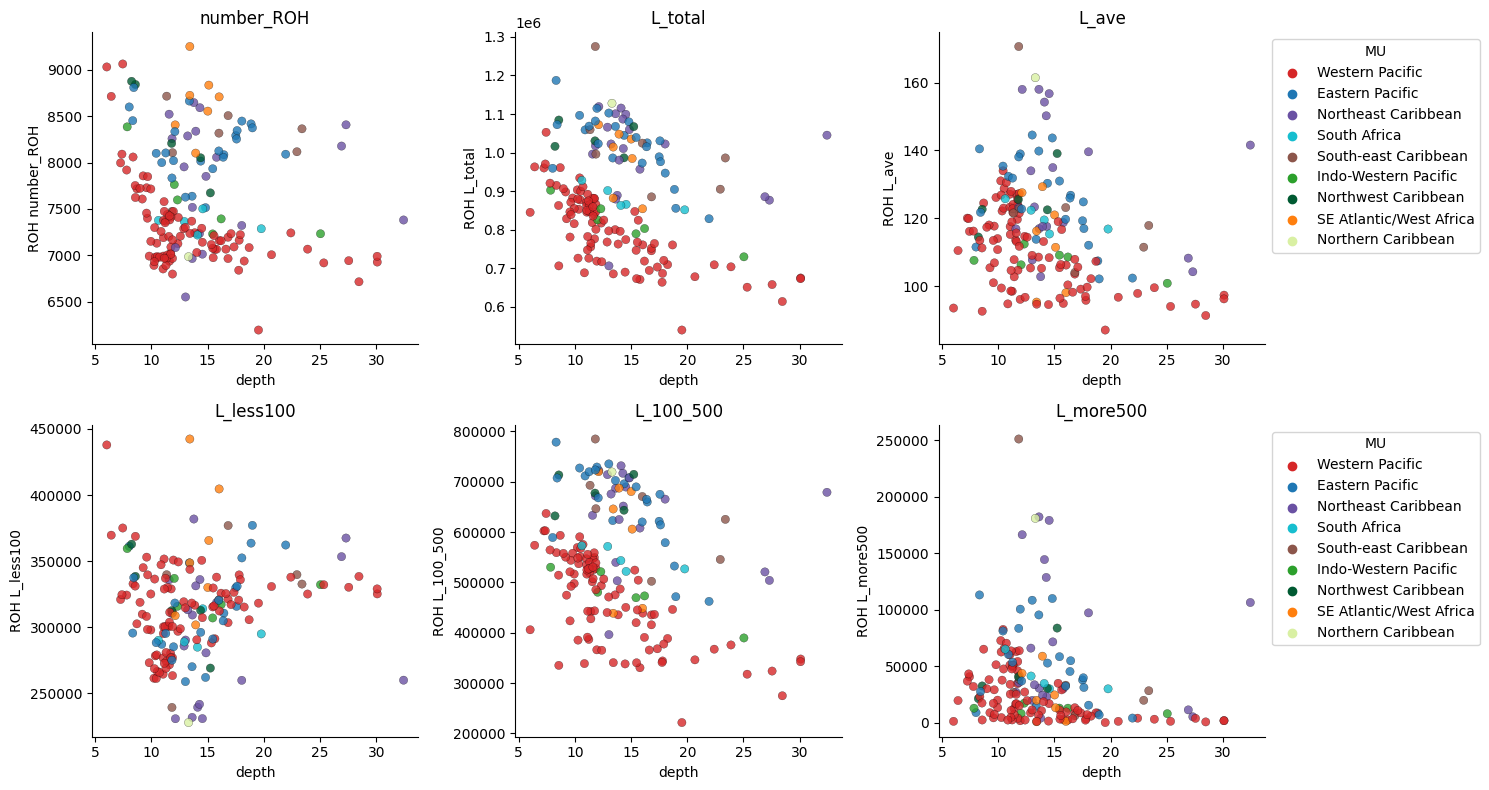

In [145]:
fig, axes = plt.subplots(2, 3, figsize = (15, 8))
group = 'MU'
p = color_dict[group]

## select only one round of PLINK ROH params
q = 20
round_q = 'from_Lisa_window_{}'.format(q)
df_temp = df_all_roh[df_all_roh['round'] == round_q]
df_temp = df_temp[df_temp['exclude'] == 'include']

values = ['number_ROH', 'L_total', 'L_ave', 'L_less100', 'L_100_500', 'L_more500']
x = 'depth'

for k in range(len(values)):
    j = k // 3
    i = k % 3
    axi = axes[j][i]
    v = values[k]

    sns.scatterplot(ax=axi, data=df_temp, x=x, y=v, hue=group, 
                    alpha=0.8, edgecolor='k', linewidth=0.2, palette=p)

    axi.set_title(v)
    axi.set_ylabel(f'ROH {v}')
    axi.set_xlabel(x)
    if i != 2:
        axi.get_legend().set_visible(False)
    else:
        sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'ROH_by_class.depth.all.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

## 2.5. Plot L_ROH = f(F_ROH)

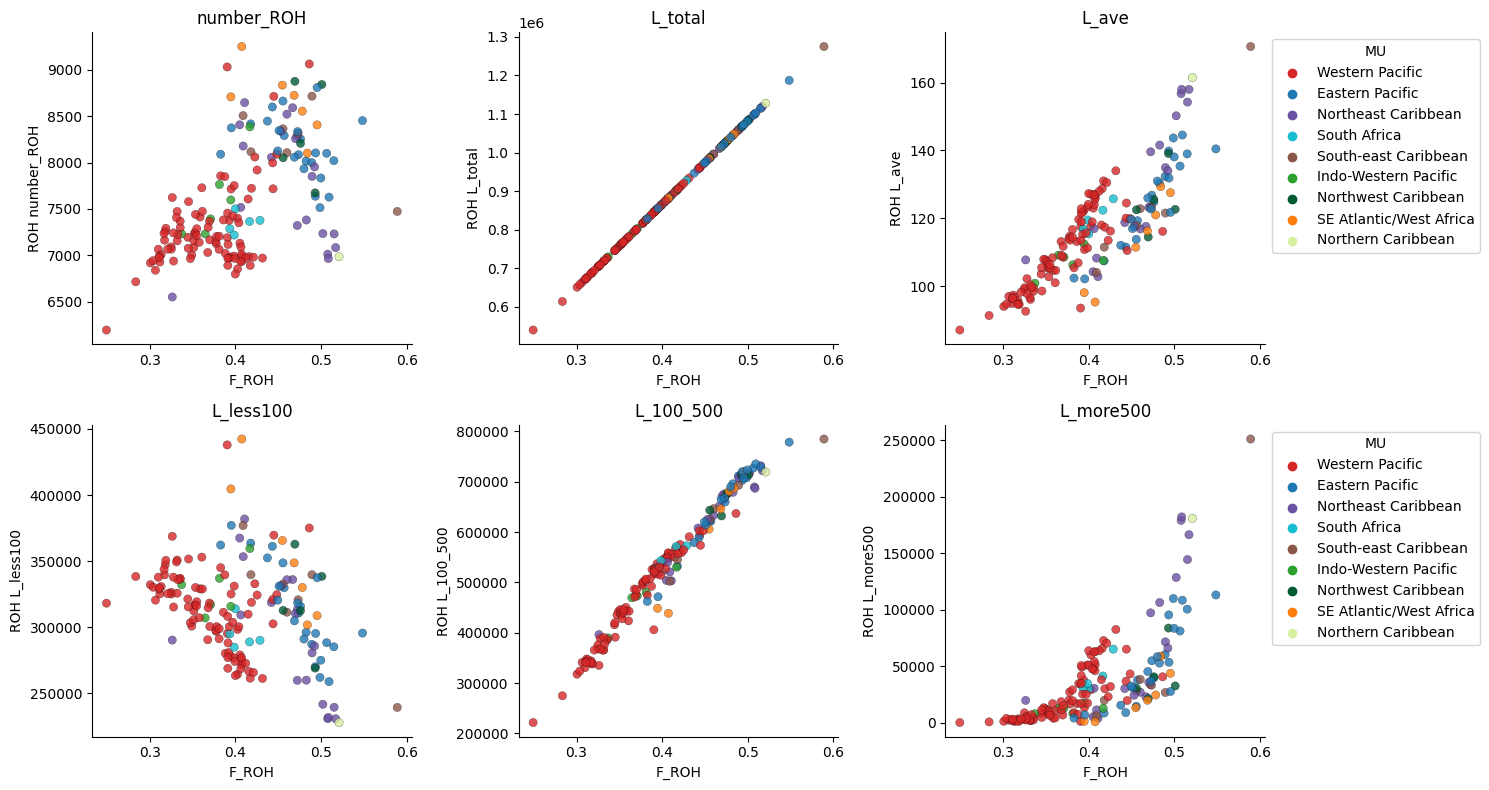

In [148]:
fig, axes = plt.subplots(2, 3, figsize = (15, 8))
group = 'MU'
p = color_dict[group]

## select only one round of PLINK ROH params
q = 20
round_q = 'from_Lisa_window_{}'.format(q)
df_temp = df_all_roh[df_all_roh['round'] == round_q]
df_temp = df_temp[df_temp['exclude'] == 'include']

values = ['number_ROH', 'L_total', 'L_ave', 'L_less100', 'L_100_500', 'L_more500']
x = 'F_ROH'

for k in range(len(values)):
    j = k // 3
    i = k % 3
    axi = axes[j][i]
    v = values[k]

    sns.scatterplot(ax=axi, data=df_temp, x=x, y=v, hue=group, 
                    alpha=0.8, edgecolor='k', linewidth=0.2, palette=p)

    axi.set_title(v)
    axi.set_ylabel(f'ROH {v}')
    axi.set_xlabel(x)
    if i != 2:
        axi.get_legend().set_visible(False)
    else:
        sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'ROH_by_class.F_ROH.all.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

## 2.6. Number of ROHs by length class in each MU

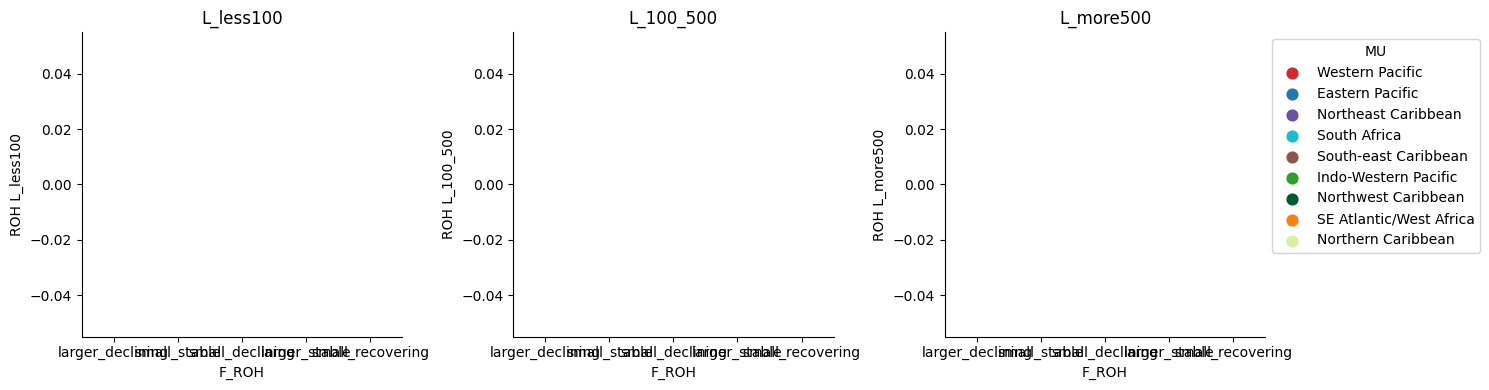

In [149]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4))
group = 'MU'
p = color_dict[group]

## select only one round of PLINK ROH params
q = 20
round_q = 'from_Lisa_window_{}'.format(q)
df_temp = df_all_roh[df_all_roh['round'] == round_q]
df_temp = df_temp[df_temp['exclude'] == 'include']

values = ['L_less100', 'L_100_500', 'L_more500']

for i in range(len(values)):
    axi = axes[i]
    v = values[i]

    sns.boxplot(ax=axi, data=df_temp, x=group, y=v, showfliers=False, 
                color="lightgrey", order=pop_order)
    sns.stripplot(ax=axi, data=df_temp, x=group, y=v, hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.1, palette=p)

    axi.set_title(v)
    axi.set_ylabel(f'ROH {v}')
    if i != 2:
        axi.get_legend().set_visible(False)
    else:
        sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'ROH_by_class.MU.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

### Plot main groups only

In [207]:
values = ['L_less100', 'L_100_500', 'L_more500', 'L_total', 'number_ROH']
pvals = []
value_stats = []

# Step 1: Collect all p-values
for v in values:
    dfi = df_temp[df_temp['group'].isin(pops)]
    data1 = dfi[dfi['group'] == g1][v]
    data2 = dfi[dfi['group'] == g2][v]
    
    # Mann–Whitney U test
    stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
    pvals.append(pval)
    value_stats.append((v, stat))

# FDR correction
rej, qvals, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

# Zip them together
value_to_qval = {v: q for (v, _), q in zip(value_stats, qvals)}

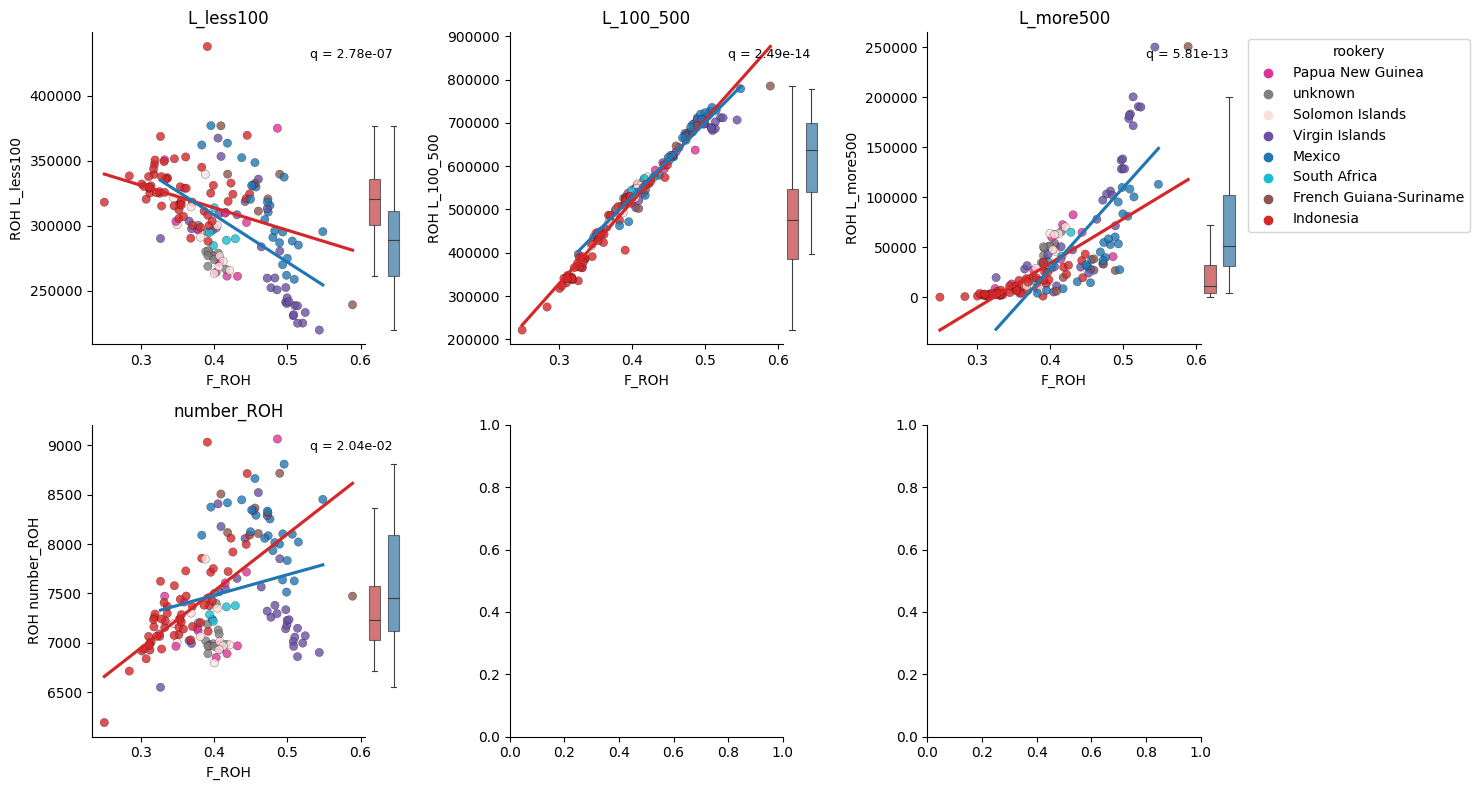

In [211]:
values = ['L_less100', 'L_100_500', 'L_more500', 'number_ROH', 'L_total']
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]
group = 'rookery'
x = 'F_ROH'

# define colors
p = color_dict[group]
p0 = color_dict['pops']
c1 = p0[g1]
c2 = p0[g2]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for k in range(len(values)):
    i = k % 3
    j = k // 3
    v = values[k]
    ax_main = axes[j][i]

    dfi = df_temp[df_temp['group'].isin(pops)]

    # Scatterplot + regression lines
    sns.regplot(ax=ax_main, data=dfi[dfi['group'] == g1], x=x, y=v, scatter=False, color=c1, ci=None)
    sns.regplot(ax=ax_main, data=dfi[dfi['group'] == g2], x=x, y=v, scatter=False, color=c2, ci=None)
    
    sns.scatterplot(ax=ax_main, data=dfi, x=x, y=v, hue=group, 
                    alpha=0.8, edgecolor='k', linewidth=0.2, palette=p)
    
    ax_main.set_title(v)
    ax_main.set_xlabel(x)
    ax_main.set_ylabel(f'ROH {v}')

    # Add tiny boxplot inset
    inset_width = 0.14
    inset_height = 1
    ax_inset = ax_main.inset_axes([1, 0, inset_width, inset_height])  # [x0, y0, width, height]

    sns.boxplot(ax=ax_inset, data=dfi, y=v, x='group', boxprops=dict(alpha=.7),
                width=0.6, fliersize=0, linewidth=0.8, palette=p0)

    # Cleanup inset axis
    ax_inset.set_xticks([])
    ax_inset.set_xlabel('')
    ax_inset.set_ylabel('')
    ax_inset.set_yticks([])
    ax_inset.set_frame_on(False)

    # Match y-axis range to main axis for alignment
    ax_inset.set_ylim(ax_main.get_ylim())

    # Add FDR above the plot
    qval = value_to_qval[v]
    ax_main.text(0.95, 0.95, f"q = {qval:.2e}", ha='center', va='top',
                 fontsize=9, transform=ax_main.transAxes)
    # Legend
    if i != 2:
        ax_main.get_legend().set_visible(False)
    else:
        sns.move_legend(ax_main, "upper left", bbox_to_anchor=(1.15, 1))

sns.despine()
fig.tight_layout()

pdf_name = 'ROH_by_class.F_ROH.L_S.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

### Plot F_ROH only

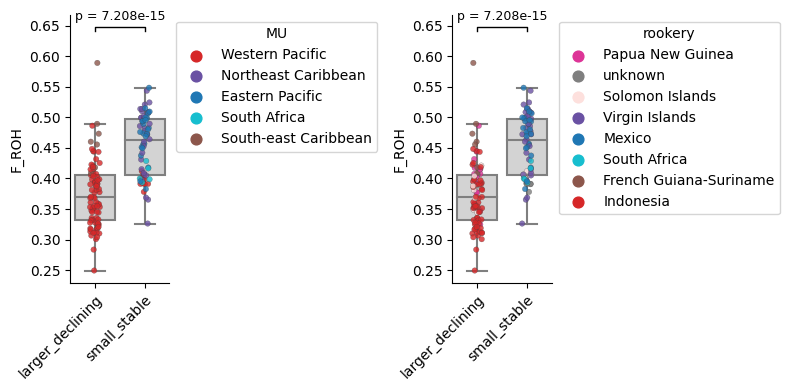

In [213]:
groups = ['MU', 'rookery']
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]
y = 'F_ROH'

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for j in range(len(groups)):
    axi = axes[j]
    dfi = df_temp[df_temp['exclude'] == 'include']
    dfi = dfi[dfi['group'].isin(pops)]
    dfi = dfi[['sample', 'F_ROH', 'group'] + groups].drop_duplicates()

    group = groups[j]
    p = color_dict[group]

    # Subset data per population
    data1 = dfi[dfi['group'] == g1][y]
    data2 = dfi[dfi['group'] == g2][y]

    # Perform Mann–Whitney U test
    stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')

    sns.boxplot(ax=axi, data=dfi, x='group', y=y, showfliers=False, color="lightgrey")
    sns.stripplot(ax=axi, data=dfi, x='group', y=y, hue=group, 
                  alpha=0.8, s=4, linewidth=0.2, palette=p)

    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
#     axi.set_ylabel(f'number of {variant}, per Mb')
    axi.set_xlabel('')
#     axi.set_ylim(400, 800)

    # Add bar and p-value
    y_max = max(dfi[y]) * 1.1
    axi.plot([0, 0, 1, 1], [y_max * 0.99, y_max, y_max, y_max * 0.99], lw=1, color='black')
    axi.text(0.5, y_max * 1.01, f"p = {pval:.3e}", ha='center', va='bottom', fontsize=9)

    sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'F_ROH.L_S.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

### Plot number of homozygotes by impact as a function of inbreeding coefficient (F_ROH)
#### Consider only SNPs (exclude indels)

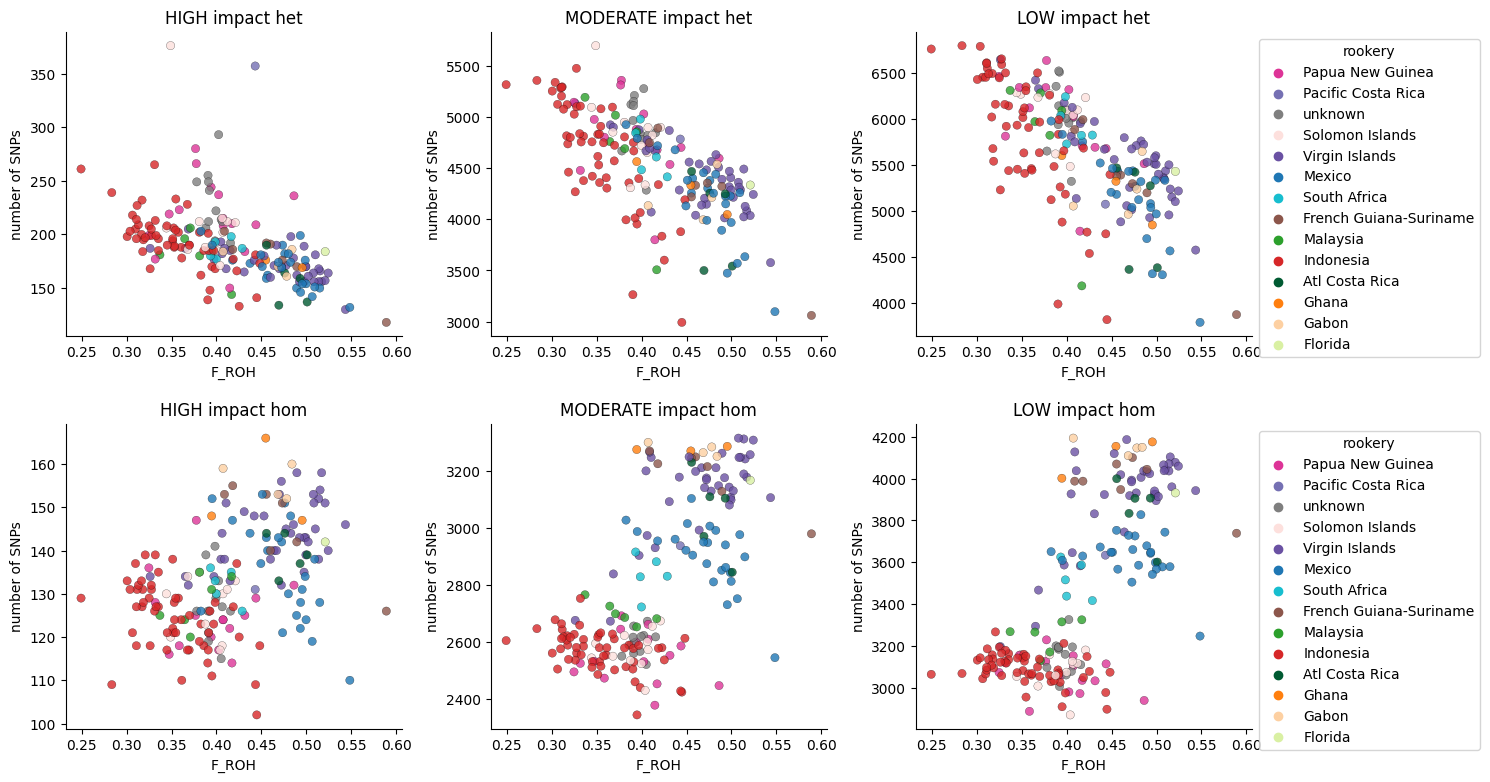

In [214]:
var = 'snps'
x = 'F_ROH'
v = 'number'
df_temp = df_roh_merged[(df_roh_merged['variant'] == var)]
df_temp = df_temp[df_temp['exclude'] == 'include']

states = list(set(df_temp['state']))
impacts = ['HIGH', 'MODERATE', 'LOW']

fig, axes = plt.subplots(2, 3, figsize = (15, 8))

for j in range(len(states)):
    for i in range(len(impacts)):
        state = states[j]
        impact = impacts[i]
        axi = axes[j][i]
        dfi = df_temp[(df_temp['impact'] == impact) & (df_temp['state'] == state)]

        sns.scatterplot(ax=axi, data=dfi, x=x, y=v, hue=group, 
                        alpha=0.8, edgecolor='k', linewidth=0.2, palette=p)
        
        axi.set_title('{} impact {}'.format(impact, state))
        axi.set_ylabel('number of SNPs')
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'homs_hets_by_impact.F_ROH.all.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

### Plot main groups only

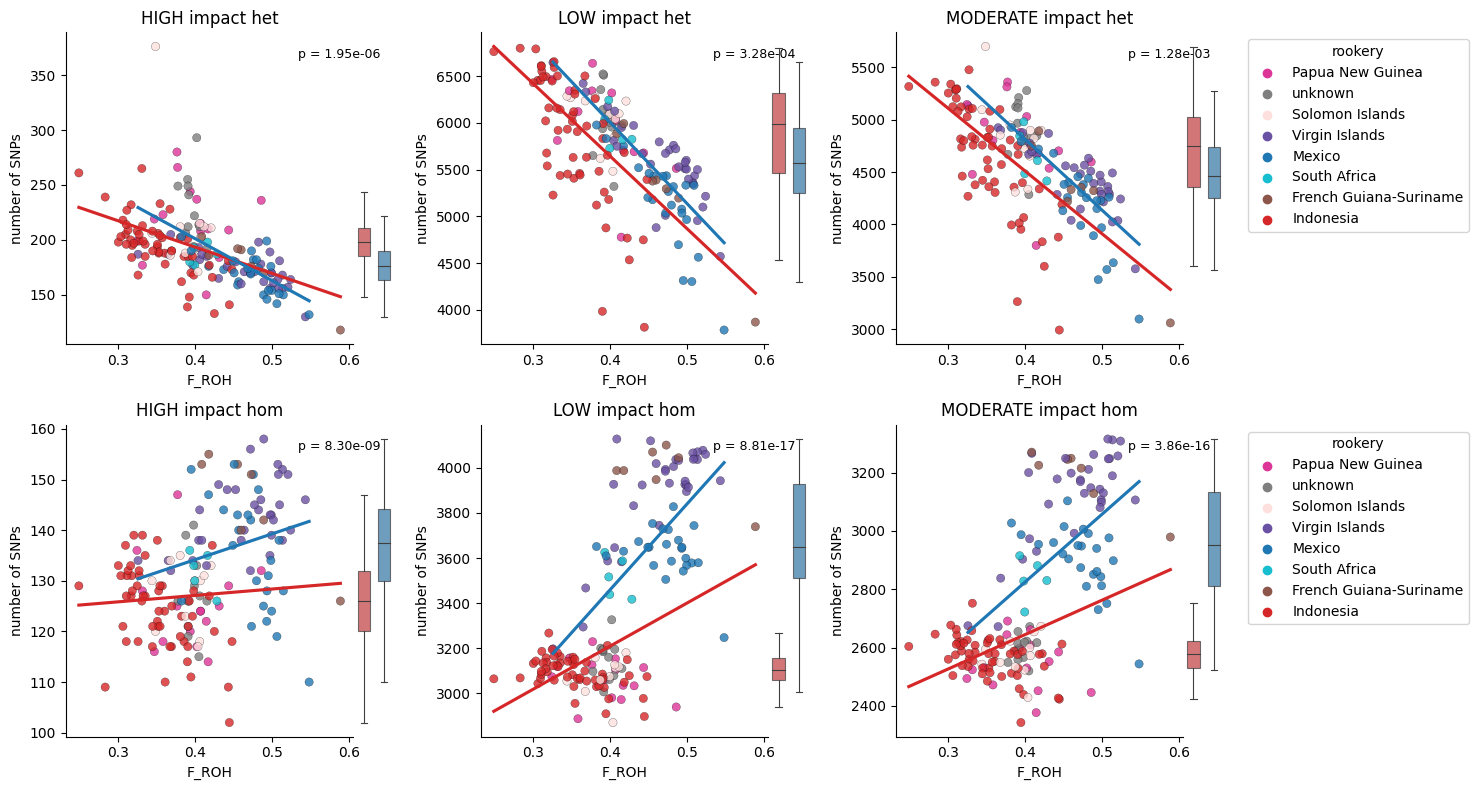

In [215]:
var = 'snps'
x = 'F_ROH'
y = 'number'
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]
group = 'rookery'

# define colors
p = color_dict[group]
p0 = color_dict['pops']
c1 = p0[g1]
c2 = p0[g2]

df_temp = df_roh_merged[(df_roh_merged['variant'] == var)]
df_temp = df_temp[df_temp['exclude'] == 'include']

states = list(set(df_temp['state']))
impacts = list(set(df_temp['impact']) - set(['MODIFIER']))

fig, axes = plt.subplots(2, 3, figsize = (15, 8))

for j in range(len(states)):
    for i in range(len(impacts)):
        state = states[j]
        impact = impacts[i]
        ax_main = axes[j][i]
        dfi = df_temp[(df_temp['impact'] == impact) & (df_temp['state'] == state)]

        dfi = dfi[dfi['group'].isin(pops)]
        
        # Subset data per population
        data1 = dfi[dfi['group'] == g1][y]
        data2 = dfi[dfi['group'] == g2][y]

        # Perform Mann–Whitney U test
        stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')

        # Scatterplot + regression lines
        sns.regplot(ax=ax_main, data=dfi[dfi['group'] == g1], x=x, y=y, scatter=False, color=c1, ci=None)
        sns.regplot(ax=ax_main, data=dfi[dfi['group'] == g2], x=x, y=y, scatter=False, color=c2, ci=None)

        sns.scatterplot(ax=ax_main, data=dfi, x=x, y=y, hue=group, 
                        alpha=0.8, edgecolor='k', linewidth=0.2, palette=p)

        ax_main.set_title(y)
        ax_main.set_xlabel(x)

        # Add tiny boxplot inset
        inset_width = 0.14
        inset_height = 1
        ax_inset = ax_main.inset_axes([1, 0, inset_width, inset_height])  # [x0, y0, width, height]

        sns.boxplot(ax=ax_inset, data=dfi, y=y, x='group', boxprops=dict(alpha=.7),
                    width=0.6, fliersize=0, linewidth=0.8, palette=p0)

        # Cleanup inset axis
        ax_inset.set_xticks([])
        ax_inset.set_xlabel('')
        ax_inset.set_ylabel('')
        ax_inset.set_yticks([])
        ax_inset.set_frame_on(False)

        # Match y-axis range to main axis for alignment
        ax_inset.set_ylim(ax_main.get_ylim())

        # Add p-value above the plot
        ax_main.text(0.95, 0.95, f"p = {pval:.2e}", ha='center', va='top',
                         fontsize=9, transform=ax_main.transAxes)
        
        ax_main.set_title('{} impact {}'.format(impact, state))
        ax_main.set_ylabel('number of SNPs')
        if i != 2:
            ax_main.get_legend().set_visible(False)
        else:
            sns.move_legend(ax_main, "upper left", bbox_to_anchor=(1.2, 1))
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'homs_hets_by_impact.F_ROH.L_S.pdf'
fig.savefig(pdf_name, bbox_inches='tight')

# Temporal Analysis

## ROH = f(t) Mexico, Indonesia, and Virgin Islands

In [27]:
df_roh_merged.head(3)

sample     F_ROH  number_ROH   L_less100   L_100_500  L_more500    impact  \
0  Z005878  0.602705       10232  390751.609  835036.509  78925.356      HIGH   
1  Z005878  0.602705       10232  390751.609  835036.509  78925.356  MODERATE   
2  Z005878  0.602705       10232  390751.609  835036.509  78925.356       LOW   

  state  number variant             rookery    year             group  \
0   hom     125    snps  Pacific Costa Rica  1994.0  larger_declining   
1   hom    2697    snps  Pacific Costa Rica  1994.0  larger_declining   
2   hom    3352    snps  Pacific Costa Rica  1994.0  larger_declining   

                MU  depth  exclude               batch  
0  Eastern Pacific   6.22  exclude  novo42_Illumina_SR  
1  Eastern Pacific   6.22  exclude  novo42_Illumina_SR  
2  Eastern Pacific   6.22  exclude  novo42_Illumina_SR

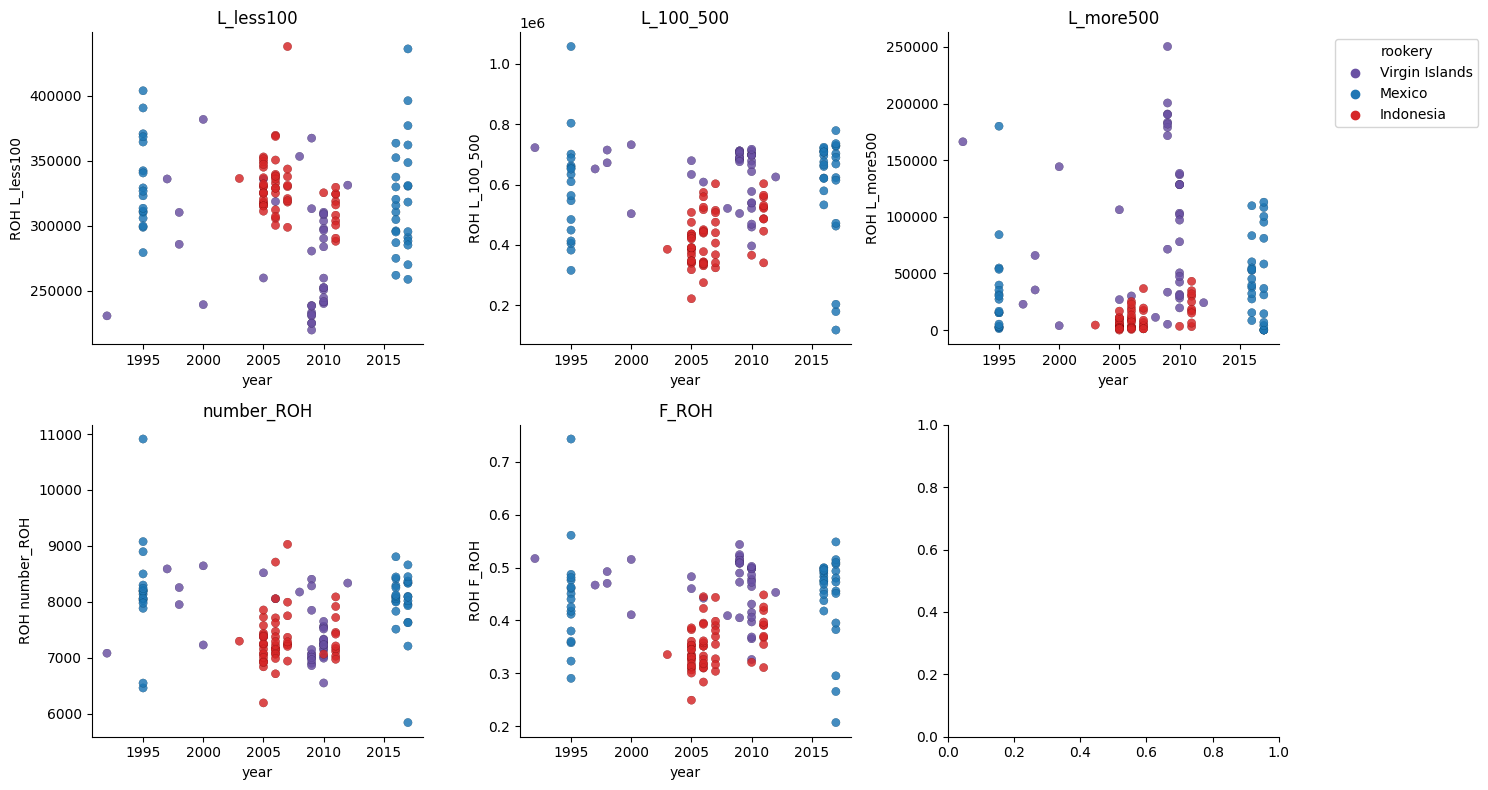

In [58]:
values = ['L_less100', 'L_100_500', 'L_more500', 'number_ROH', 'F_ROH']
group = 'rookery'
x = 'year'
temporal_groups = ['Mexico', 'Virgin Islands', 'Indonesia']
p = color_dict[group]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for k in range(len(values)):
    i = k % 3
    j = k // 3
    v = values[k]
    ax_main = axes[j][i]

    dfi = df_roh_merged[df_roh_merged[group].isin(temporal_groups)]
    
    sns.scatterplot(ax=ax_main, data=dfi, x=x, y=v, hue=group, 
                    alpha=0.2, edgecolor='k', linewidth=0.05, palette=p)
    
    ax_main.set_title(v)
    ax_main.set_xlabel(x)
    ax_main.set_ylabel(f'ROH {v}')

    if i != 2:
        ax_main.get_legend().set_visible(False)
    else:
        sns.move_legend(ax_main, "upper left", bbox_to_anchor=(1.15, 1))

sns.despine()
fig.tight_layout()

pdf_name = 'temporal.ROH_by_class_F_ROH.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

## Genetic load = f(t) Mexico, Indonesia, and Virgin Islands

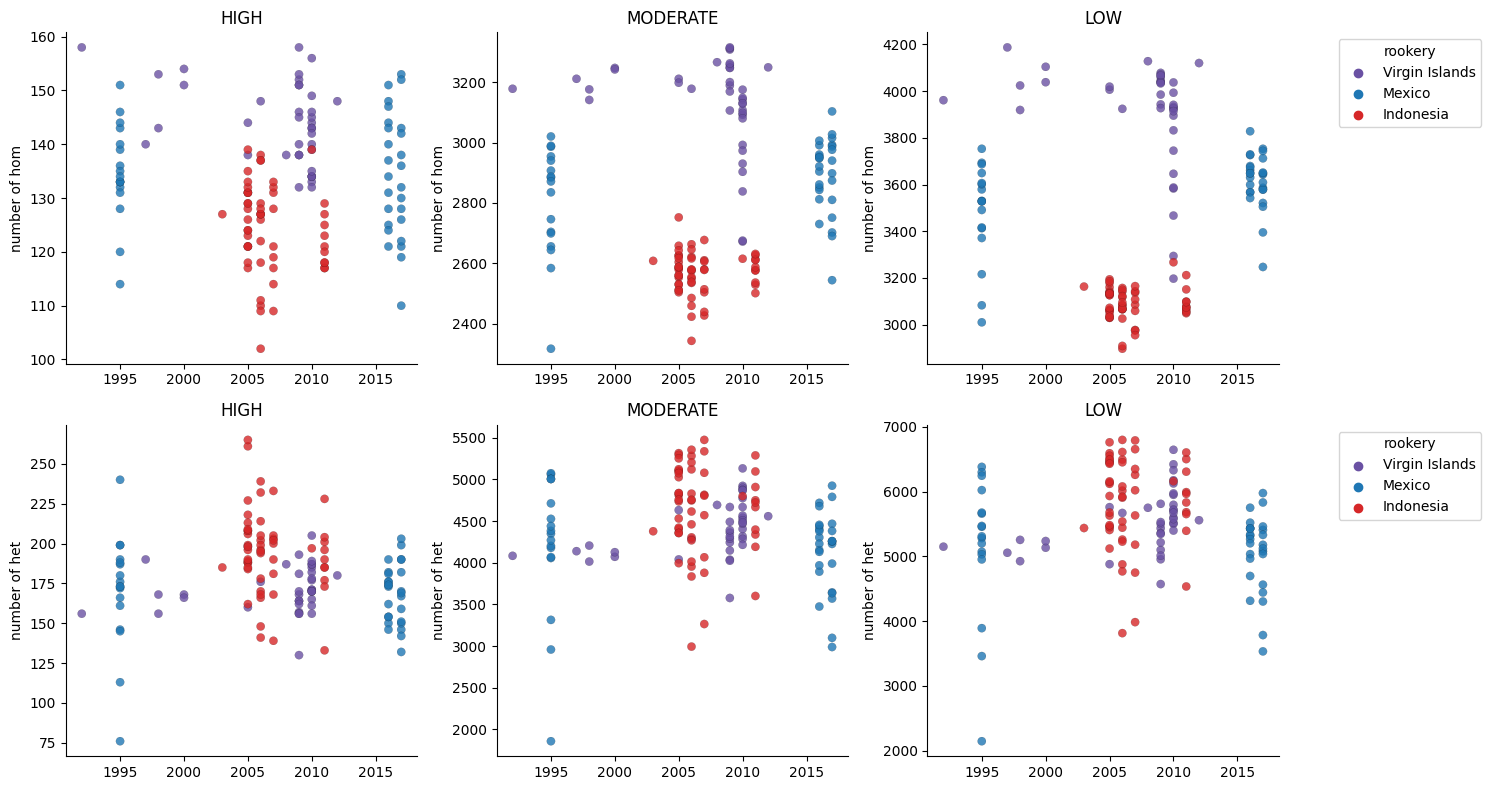

In [60]:
states = list(set(df_roh_merged['state']))
impacts = ['HIGH', 'MODERATE', 'LOW']
x = 'year'
y = 'number'

group = 'rookery'
temporal_groups = ['Mexico', 'Virgin Islands', 'Indonesia']
p = color_dict[group]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i in range(len(impacts)):
    for j in range(len(states)):
        impact = impacts[i]
        state = states[j]
        ax_main = axes[j][i]

        dfi = df_roh_merged[df_roh_merged[group].isin(temporal_groups)]
        dfi = dfi[(dfi['state'] == state) & (dfi['impact'] == impact)]

        sns.scatterplot(ax=ax_main, data=dfi, x=x, y=y, hue=group, 
                        alpha=0.8, edgecolor='k', linewidth=0.1, palette=p)

        ax_main.set_title(f'{impact}')
        ax_main.set_ylabel(f'number of {state}')
        ax_main.set_xlabel('')
        
        if i != 2:
            ax_main.get_legend().set_visible(False)
        else:
            sns.move_legend(ax_main, "upper left", bbox_to_anchor=(1.15, 1))

sns.despine()
fig.tight_layout()

pdf_name = 'temporal.ROH_by_class_F_ROH.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')